In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
import numpy as np
import pickle
pickle_in=open("x2.pickle","rb")
x=pickle.load(pickle_in)
pickle_iny=open("y2.pickle","rb")
y=pickle.load(pickle_iny)

In [4]:
pickle_in=open("data1.pickle","rb")
x1=pickle.load(pickle_in)
pickle_iny=open("label1.pickle","rb")
y1=pickle.load(pickle_iny)

In [5]:
y1

array(['without_mask', 'without_mask', 'without_mask', ..., 'with_mask',
       'with_mask', 'with_mask'], dtype='<U12')

In [6]:
lb = LabelBinarizer()
y1 = lb.fit_transform(y1)
y1 = to_categorical(y1)

In [7]:
lb = LabelBinarizer()
y = lb.fit_transform(y)
y = to_categorical(y)

In [8]:
data = np.concatenate((x1, x))
labels= np.concatenate((y1, y))

In [10]:
len(data)

5675

In [11]:
x

[array([[[120, 154, 184],
         [126, 159, 192],
         [132, 166, 199],
         ...,
         [115, 131, 175],
         [ 97, 114, 157],
         [ 77,  86, 130]],
 
        [[121, 154, 185],
         [127, 160, 193],
         [132, 166, 199],
         ...,
         [ 88, 103, 147],
         [ 92, 105, 149],
         [ 97, 110, 154]],
 
        [[120, 156, 186],
         [126, 161, 194],
         [133, 168, 201],
         ...,
         [ 91, 102, 149],
         [ 98, 108, 155],
         [118, 133, 176]],
 
        ...,
 
        [[ 57,  42,  94],
         [ 63,  48,  99],
         [ 69,  54, 104],
         ...,
         [ 63,  34,  50],
         [ 60,  31,  46],
         [ 53,  26,  42]],
 
        [[ 65,  52, 103],
         [ 69,  56, 106],
         [ 72,  57, 107],
         ...,
         [ 60,  31,  47],
         [ 57,  28,  44],
         [ 52,  25,  41]],
 
        [[ 70,  60, 111],
         [ 66,  55, 104],
         [ 68,  54, 102],
         ...,
         [ 57,  28,  44],
  

In [50]:
data = np.array(x, dtype="float64")
labels = np.array(y)

In [12]:
#lb = LabelBinarizer()
#labels = lb.fit_transform(labels)
#labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [19]:
testX

array([[[[ 74.,  61.,  59.],
         [ 74.,  61.,  59.],
         [ 75.,  62.,  60.],
         ...,
         [ 90.,  92., 103.],
         [119., 121., 132.],
         [124., 126., 137.]],

        [[ 75.,  62.,  60.],
         [ 75.,  62.,  60.],
         [ 74.,  61.,  59.],
         ...,
         [ 88.,  90., 101.],
         [118., 120., 131.],
         [123., 125., 136.]],

        [[ 78.,  65.,  63.],
         [ 77.,  64.,  62.],
         [ 73.,  60.,  58.],
         ...,
         [ 85.,  87.,  98.],
         [117., 119., 130.],
         [121., 123., 134.]],

        ...,

        [[ 63.,  54.,  51.],
         [ 63.,  53.,  51.],
         [ 58.,  49.,  46.],
         ...,
         [ 37.,  39.,  39.],
         [ 41.,  43.,  43.],
         [ 41.,  43.,  43.]],

        [[ 60.,  51.,  48.],
         [ 60.,  51.,  48.],
         [ 58.,  49.,  46.],
         ...,
         [ 36.,  38.,  38.],
         [ 38.,  40.,  40.],
         [ 39.,  40.,  40.]],

        [[ 59.,  50.,  47.],
       

In [13]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [14]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
141/141 [==============================] - 139s 983ms/step - loss: 0.4942 - accuracy: 0.7666 - val_loss: 0.2869 - val_accuracy: 0.9048
Epoch 2/20
141/141 [==============================] - 131s 928ms/step - loss: 0.3078 - accuracy: 0.8776 - val_loss: 0.2242 - val_accuracy: 0.9216
Epoch 3/20
141/141 [==============================] - 127s 898ms/step - loss: 0.2747 - accuracy: 0.8929 - val_loss: 0.2072 - val_accuracy: 0.9189
Epoch 4/20
141/141 [==============================] - 135s 957ms/step - loss: 0.2491 - accuracy: 0.9031 - val_loss: 0.1883 - val_accuracy: 0.9295
Epoch 5/20
141/141 [==============================] - 133s 940ms/step - loss: 0.2313 - accuracy: 0.9115 - val_loss: 0.1774 - val_accuracy: 0.9322
Epoch 6/20
141/141 [==============================] - 134s 947ms/step - loss: 0.2200 - accuracy: 0.9164 - val_loss: 0.1667 - val_accuracy: 0.9330
Epoch 7/20
141/141 [==============================] - 130s 924ms/step - lo

In [22]:
testY[1]


array([1., 0.], dtype=float32)

In [17]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
# print(classification_report(testY.argmax(axis=1), predIdxs,
# 	target_names=lb.classes_))
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("modelcomb", save_format="h5")

[INFO] evaluating network...
[INFO] saving mask detector model...


In [24]:
#print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

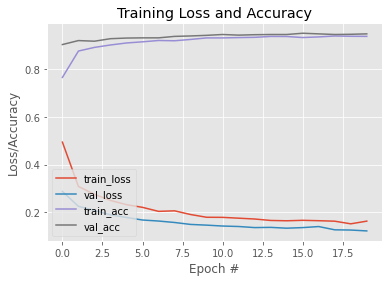

In [18]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot")

In [19]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os

In [21]:
print("[INFO] loading face detector model...")
prototxtPath = "deploy.prototxt"
weightsPath = "res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNet(prototxtPath, weightsPath)
# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model("modelcomb")

[INFO] loading face detector model...
[INFO] loading face mask detector model...


In [46]:
image = cv2.imread("3.jpg")
orig = image.copy()
(h, w) = image.shape[:2]
# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))
# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()
for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with
    # the detection
    confidence = detections[0, 0, i, 2]
    # filter out weak detections by ensuring the confidence is
    # greater than the minimum confidence
    if confidence > 0.2 :
        # compute the (x, y)-coordinates of the bounding box for
        # the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        # ensure the bounding boxes fall within the dimensions of
        # the frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
        # extract the face ROI, convert it from BGR to RGB channel
        # ordering, resize it to 224x224, and preprocess it
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)
        # pass the face through the model to determine if the face
        # has a mask or not
        (mask, withoutMask) = model.predict(face)[0]
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(image, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
# show the output image
cv2.imshow("Output", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

[INFO] computing face detections...


In [26]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os

In [27]:
def detect_and_predict_mask(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
        (104.0, 177.0, 123.0))
    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]
        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            # add the face and bounding boxes to their respective
            # lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))
        if len(faces) > 0:
            # for faster inference we'll make batch predictions on *all*
            # faces at the same time rather than one-by-one predictions
            # in the above `for` loop
            faces = np.array(faces, dtype="float32")
            preds = maskNet.predict(faces, batch_size=32)
            # return a 2-tuple of the face locations and their corresponding
            # locations
        return (locs, preds)

In [49]:
print("[INFO] loading face detector model...")
prototxtPath = "deploy.prototxt"
weightsPath = "res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)
# # load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
maskNet = load_model("modelcomb")
# # initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)
while True:
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
    frame = vs.read()
    frame = imutils.resize(frame, width=400)
    # detect faces in the frame and determine if they are wearing a
    # face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)
    for (box, pred) in zip(locs, preds):
        # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred
        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(frame, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
# show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] starting video stream...


In [34]:
import numpy as np
import cv2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
cap = cv2.VideoCapture(0)
print("[INFO] loading face detector model...")
prototxtPath = "deploy.prototxt"
weightsPath = "res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNet(prototxtPath, weightsPath)
# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model("modelcomb")
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    gray = frame
    orig = gray.copy()
    (h, w) = gray.shape[:2]
# construct a blob from the image
    blob = cv2.dnn.blobFromImage(gray, 1.0, (300, 300),
    (104.0, 177.0, 123.0))
# pass the blob through the network and obtain the face detections
    print("[INFO] computing face detections...")
    net.setInput(blob)
    detections = net.forward()
    for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with
    # the detection
        confidence = detections[0, 0, i, 2]
    # filter out weak detections by ensuring the confidence is
    # greater than the minimum confidence
        if confidence > 0.6 :
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = image[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)
            # pass the face through the model to determine if the face
            # has a mask or not
            (mask, withoutMask) = model.predict(face)[0]
            label = "Mask" if mask > withoutMask else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
            # include the probability in the label
            label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
            # display the label and bounding box rectangle on the output
            # frame
            cv2.putText(image, label, (startX, startY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)


    # Display the resulting frame
    cv2.imshow('frame',gray)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing face detections...
[INFO] computing fa

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])